# Table of Reference

1. [Assumptions](#Assumptions)
    1. [Constraints](#Constraints)
2. [Addition of Time Interval](#Time)
3. [Exploratory Data Analysis](#EDA)
    1. [Outlier Handling](#Outlier)
    2. [Correlation](#Correlation)
    3. [Distributions](#Distributions)
4. [Hypothesis Testing](#Hypothesis)
    1. [Hypothesis 1](#H1)
    2. [Hypothesis 2](#H2)

In [258]:
###############################################################
import pandas as pd
import numpy as np
from datetime import datetime 
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import statsmodels.api as sm
import scipy.stats as stats
###############################################################

In [259]:
df=pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')

## <a name="Assumptions"></a>Assumptions taken

1. Scope of data: Before 31st January 2020
    Reason: Pre-pandemic data is considered here because a lot of factors have come into play post that period, mainly the idea of Remote work and popularity of streaming services. It would not make sense to consider data post the spread of the pandemic. 
    
2. Definition of Churn: As per the documentation, churn is defined as all the people that did not use the services in this month (or last month if we are looking at 1st of the current month). Based on assumption 1, this would mean that all the users that have not paid for the service after 31st December 2019 are churned users.

3. Keeping in mind that a lot of users have monthly or yearly contracts, it has to be assumed that all the monthly and yearly contracts get over on 31st December 2019 and those who renewed their subscirption after that period are non-churned users whereas those who did not renew are churned users

4. Because the data spans over 6 years, it has to be assumed that the services and external factors have stayed constant in the past 6 years and there is no change in the services / pricing / availability / workforce

5. 



### <a name="Constraints"></a>Constraints

In [ ]:
# Customer ID is unique and each row pertain to one specifc customer ID
len(df['customerID'])==df['customerID'].nunique()

In [261]:
#Tenure has to be > 0 based on the definition of churn
df[df.tenure<1]['customerID'].count()

11

In [300]:
# Monthly charges cannot be greater than total charges 
df[df['MonthlyCharges']>df['TotalCharges']]['customerID'].count()

0

In [309]:
# A user cannot opt for any of the subscriptions if internet services is not taken
df.query('InternetService=="No" and (OnlineSecurity=="Yes" or OnlineBackup=="Yes" or DeviceProtection=="Yes" or TechSupport=="Yes" or StreamingTV=="Yes" or StreamingMovies=="Yes")')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,registration_time,base,registration_year,registration_month


In [302]:
# Gender is Male/Female and does not include non-binary genders
df.gender.unique()

array(['Female', 'Male'], dtype=object)

In [303]:
# There are 3 types of contracts, it is possible that the user has churned out during their contract or they have churned out after their contract is over
df.Contract.unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [305]:
# Multiple lines are not possible without enablement of Phone service
df.query('PhoneService=="No" and MultipleLines=="Yes"')

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,registration_time,base,registration_year,registration_month


## <a name="Time"></a>Addition of Time Interval

In [263]:
df.tenure.describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64

In [264]:
from datetime import datetime
from dateutil.relativedelta import relativedelta

df['registration_time']= df.apply(lambda x: datetime.strptime('31/01/2020', '%d/%m/%Y')-relativedelta(months=x['tenure']), axis=1)


In [265]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,registration_time
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No,2019-12-31
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,No,No,No,One year,No,Mailed check,56.95,1889.5,No,2017-03-31
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2019-11-30
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No,2016-04-30
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,2019-11-30


## <a name="EDA"></a> Exploratory Data Analysis

In [266]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn',
       'registration_time'],
      dtype='object')

In [267]:
df.dtypes

customerID                   object
gender                       object
SeniorCitizen                 int64
Partner                      object
Dependents                   object
tenure                        int64
PhoneService                 object
MultipleLines                object
InternetService              object
OnlineSecurity               object
OnlineBackup                 object
DeviceProtection             object
TechSupport                  object
StreamingTV                  object
StreamingMovies              object
Contract                     object
PaperlessBilling             object
PaymentMethod                object
MonthlyCharges              float64
TotalCharges                 object
Churn                        object
registration_time    datetime64[ns]
dtype: object

In [268]:
df.TotalCharges = pd.to_numeric(df.TotalCharges, errors='coerce')
df.isnull().sum()

customerID            0
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod         0
MonthlyCharges        0
TotalCharges         11
Churn                 0
registration_time     0
dtype: int64

In [269]:
df[np.isnan(df['TotalCharges'])]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,registration_time
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,2020-01-31
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No,2020-01-31
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No,2020-01-31
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No,2020-01-31
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No,2020-01-31
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No,2020-01-31
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No,2020-01-31
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No,2020-01-31
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No,2020-01-31
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No,2020-01-31


### Observation:
The tenure column is 0 for all the users not having any charges. This is odd because based on the definition of tenure and the dataset, all the customers are supposed to have a tenure of >0.
It is possible that there was an issue with the logic that measures tenure of the users and hence total charges were also not calculated correctly.

In order to maintain the characteristic of the data, these rows having 0 tenure duration need to be excluded.

In [270]:
df[df['tenure']==0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,registration_time
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No,2020-01-31
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No,2020-01-31
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No,2020-01-31
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No,2020-01-31
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No,2020-01-31
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No,2020-01-31
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No,2020-01-31
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No,2020-01-31
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No,2020-01-31
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No,2020-01-31


A total of 11 entries (0.001% of total data) will be excluded

In [271]:
df=df[df['tenure']>0]
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges         0
Churn                0
registration_time    0
dtype: int64

## <a name="Outlier"></a> Outlier Handling

In [272]:
df['base']=1
df.groupby('base')['TotalCharges'].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
base,,,,,,,,,,,,,,
1,7032.0,2283.300441,2266.771362,18.8,84.6,267.07,551.995,944.17,1397.475,2048.95,3141.13,4475.41,5976.64,8684.8


In [273]:

#df[df['TotalCharges']<df.groupby('base')['TotalCharges'].describe(percentiles=[0.99])['99%'][1]]
df= df[(df['TotalCharges']<df['TotalCharges'].quantile(0.99)) & (df['TotalCharges']>df['TotalCharges'].quantile(0.01))]
  

In [274]:
df['TotalCharges'].quantile(0.99)

7723.7339999999995

- The top 1% and bottom 1% of the users (based on their total charges) are considered as outliers and are removed.
 
- Techniqies such as Z score are not used because the data is not normally distributed

## <a name="Correlation"></a>Correlation

There is a mix of Numerical variables as well as Categorical variables. Pearson's coefficient for correlation does not work on categorical variables.
However, categorical variables can be converted to their numerical representation to give an accurate measure of correlation. An alternative to this is the chi-squared test to measure the relationship between two categorical variables.

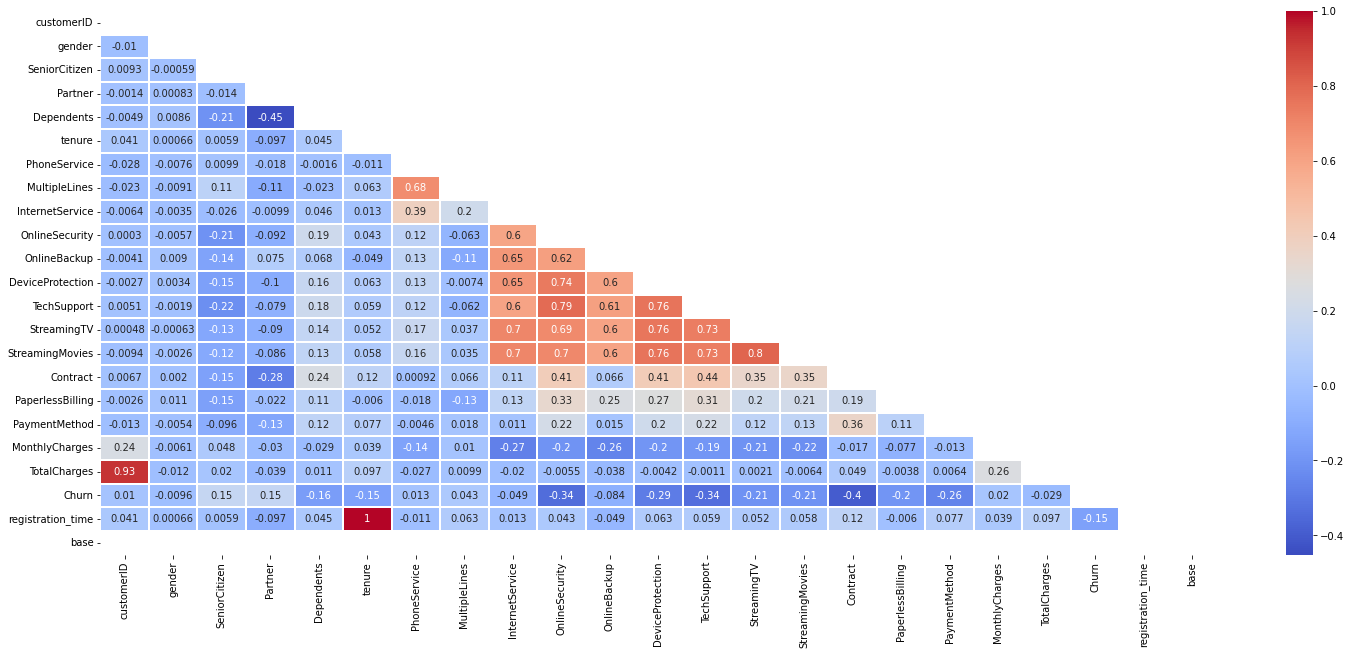

In [275]:
plt.figure(figsize=(25,10))

corr = df.apply(lambda x: pd.factorize(x)[0]).corr()

mask = np.triu(np.ones_like(corr, dtype=bool))

ax = sns.heatmap(corr, mask=mask, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, linewidths=.2, cmap="coolwarm")



Observations:

1. Subscription based services (Internet services, Online Security, Online Backup, Device Protection, TechSupport, Streaming TV and Steaming Movies) are highly correlated to each other. 
    Plausible reason: Generally, customers prefer taking multiple services from the same company for many reasons like convenience, compatibility, uniformity etc. Certain patterns are clearly visible, for example:
    1. The correlation of Internet Service with all the other subscription services. People who subscribe for internet would naturally want to utilize the most that they can get out of that service, so they could opt for Online Backup, Streaming TV/Movies, Online Security, etc. 
    2. People who opt for Online Backup would have a tendency to take Online Security/Device Protection for their backup to be safe. 
    3.Customers opting for multiple services would have frequent interactions with the Technical support team for small problems and hiccups, hence Technical support is highly correlated to the other services as well
    
2. Dependents is significantly correlated to Partner, which signifies that a lot of people that have partners as dependents, and could also signify that a lot of people having dependents also have partners.

3. Contract seems to be negatively correlated to Churn, which would imply that shorter contracts correspond to higher churn

4. Variables that are significantly correlated to churn are Online Security, Device Protection, Tech Support, Payment Method

5. Phone Service is highly correlated to Multiple Lines, implying that all the users that have a phone service suprscription have it in the form of multiple phone lines and not a single one

## <a name="Distributions"></a>Distributions

#### Tenure


D:\pythonProject\Razorpay\churn_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '# of Customers by their tenure')

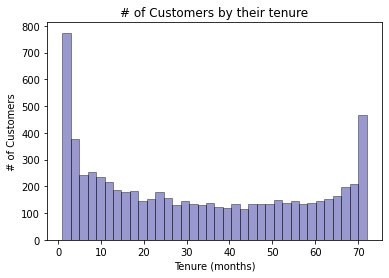

In [276]:


ax = sns.distplot(df['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('# of Customers by their tenure')



In [277]:
#### Monthly Charges

Text(0.5, 1.0, '# of Customers by their Monthly Charges')

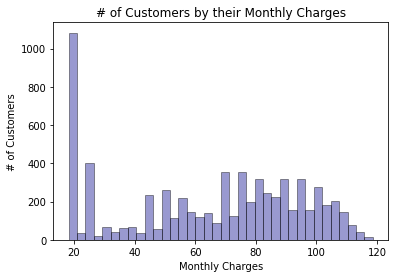

In [278]:
ax = sns.distplot(df['MonthlyCharges'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Monthly Charges')
ax.set_title('# of Customers by their Monthly Charges')

In [279]:
#### Total Charges

Text(0.5, 1.0, '# of Customers by their Total Charges')

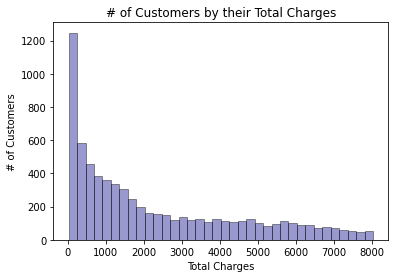

In [280]:
ax = sns.distplot(df['TotalCharges'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Total Charges')
ax.set_title('# of Customers by their Total Charges')

#### Gender

Text(0.5, 1.0, 'Gender Distribution')

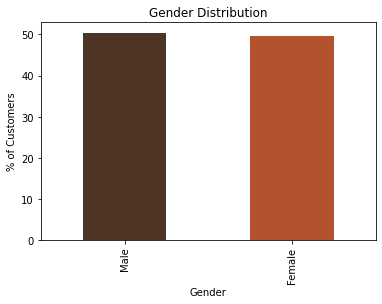

In [281]:
colors = ['#4D3425','#B4512F']
ax = (df['gender'].value_counts()*100.0 /len(df)).plot(kind='bar', color = colors)

ax.set_ylabel('% of Customers')
ax.set_xlabel('Gender')
ax.set_ylabel('% of Customers')
ax.set_title('Gender Distribution')

#### SeniorCitizen

Text(0.5, 1.0, 'Seniority Distribution')

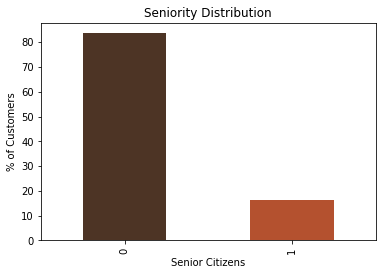

In [282]:
colors = ['#4D3425','#B4512F']
ax = (df['SeniorCitizen'].value_counts()*100.0 /len(df)).plot(kind='bar', color = colors)

ax.set_ylabel('% of Customers')
ax.set_xlabel('Senior Citizens')
ax.set_ylabel('% of Customers')
ax.set_title('Seniority Distribution')

#### Senior Citizens with their Gender

<AxesSubplot:xlabel='SeniorCitizen', ylabel='count'>

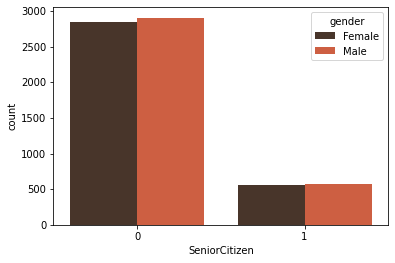

In [283]:
sns.countplot(
    x='SeniorCitizen', 
    data=df, 
    palette=['#4D3425','#E4512B'],
    hue='gender')

Text(0.5, 1.0, 'Dependents Distribution')

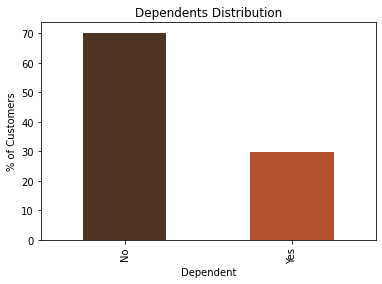

In [284]:
colors = ['#4D3425','#B4512F']
ax = (df['Dependents'].value_counts()*100.0 /len(df)).plot(kind='bar', color = colors)

ax.set_ylabel('% of Customers')
ax.set_xlabel('Dependent')
ax.set_ylabel('% of Customers')
ax.set_title('Dependents Distribution')

Text(0.5, 1.0, 'Partner Distribution')

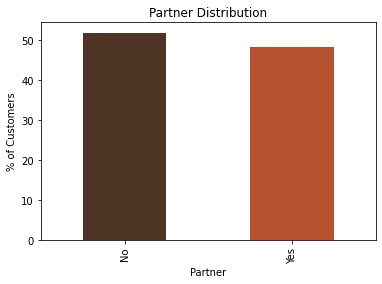

In [285]:
colors = ['#4D3425','#B4512F']
ax = (df['Partner'].value_counts()*100.0 /len(df)).plot(kind='bar', color = colors)

ax.set_ylabel('% of Customers')
ax.set_xlabel('Partner')
ax.set_ylabel('% of Customers')
ax.set_title('Partner Distribution')

#### Partner and Dependent

<AxesSubplot:xlabel='Dependents', ylabel='count'>

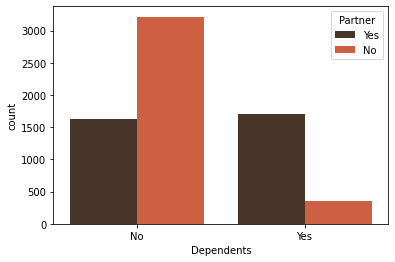

In [286]:
sns.countplot(
    x='Dependents', 
    data=df, 
    palette=['#4D3425','#E4512B'],
    hue='Partner')

<AxesSubplot:xlabel='Partner', ylabel='count'>

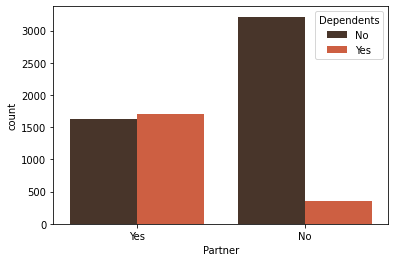

In [287]:
sns.countplot(
    x='Partner', 
    data=df, 
    palette=['#4D3425','#E4512B'],
    hue='Dependents')

#### Contract

Text(0.5, 1.0, 'Contract Distribution')

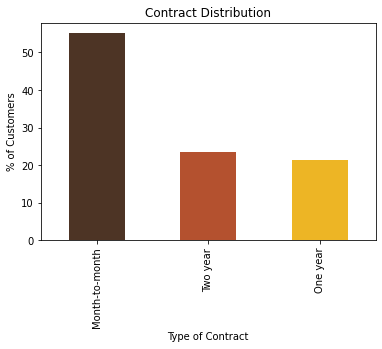

In [288]:
colors = ['#4D3425','#B4512F','#EDB525']
ax = (df['Contract'].value_counts()*100.0 /len(df)).plot(kind='bar', color = colors)

ax.set_ylabel('% of Customers')
ax.set_xlabel('Type of Contract')
ax.set_ylabel('% of Customers')
ax.set_title('Contract Distribution')

<AxesSubplot:xlabel='Churn', ylabel='count'>

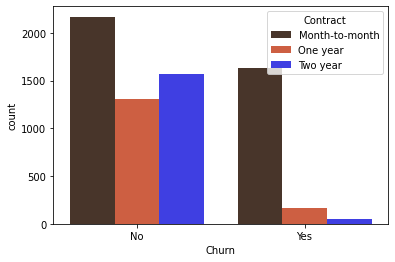

In [289]:
sns.countplot(
    x='Churn', 
    data=df, 
    palette=['#4D3425','#E4512B','#2424fd'],
    hue='Contract')

In [290]:
df['Contract'].value_counts()*100.0 /len(df)

Month-to-month    55.200465
Two year          23.518303
One year          21.281232
Name: Contract, dtype: float64

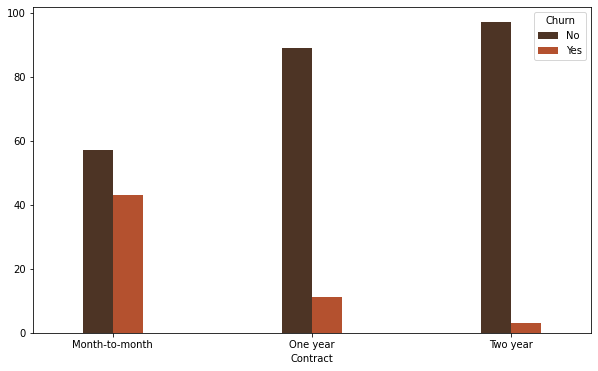

In [291]:
contract_churn = df.groupby(['Contract','Churn']).size().unstack()

ax = (contract_churn.T*100.0 / contract_churn.T.sum()).T.plot(kind='bar',
                                                                width = 0.3,
                                                                stacked = False,
                                                                rot = 0, 
                                                                figsize = (10,6),
                                                                color = colors)

#### Remaining variables

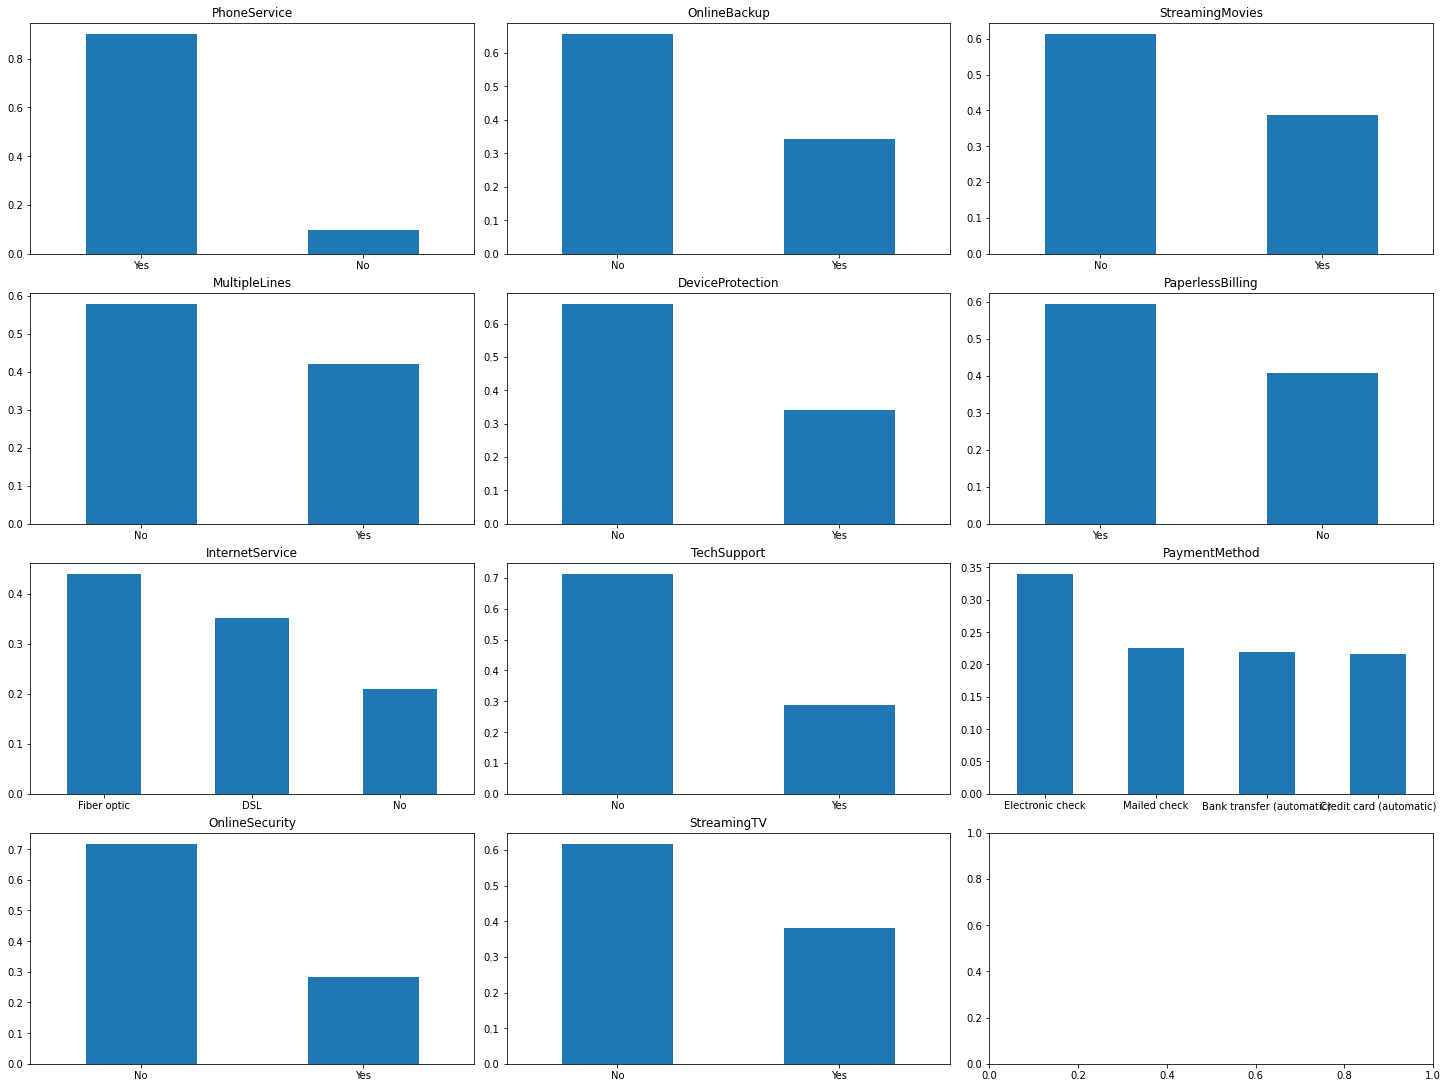

In [292]:
df=df.replace({'No internet service':'No', 'No phone service': 'No'})
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','PaymentMethod']

fig, axes = plt.subplots(nrows = 4,ncols = 3,figsize = (20,15),constrained_layout=True)
for i, item in enumerate(services):
    if i < 4:
        ax = (df[item].value_counts()/len(df)).plot(kind = 'bar',ax=axes[i,0],rot = 0)
        
    elif i >=4 and i < 8:
        ax = (df[item].value_counts()/len(df)).plot(kind = 'bar',ax=axes[i-4,1],rot = 0)
        
    elif i < 11:
        ax = (df[item].value_counts()/len(df)).plot(kind = 'bar',ax=axes[i-8,2],rot = 0)
    ax.set_title(item)
#     elif i >9 and i<12:
#         ax = (df[item].value_counts()/len(df)).plot(kind = 'bar',ax=axes[i-9,],rot = 0)
#         ax.set_title(item)

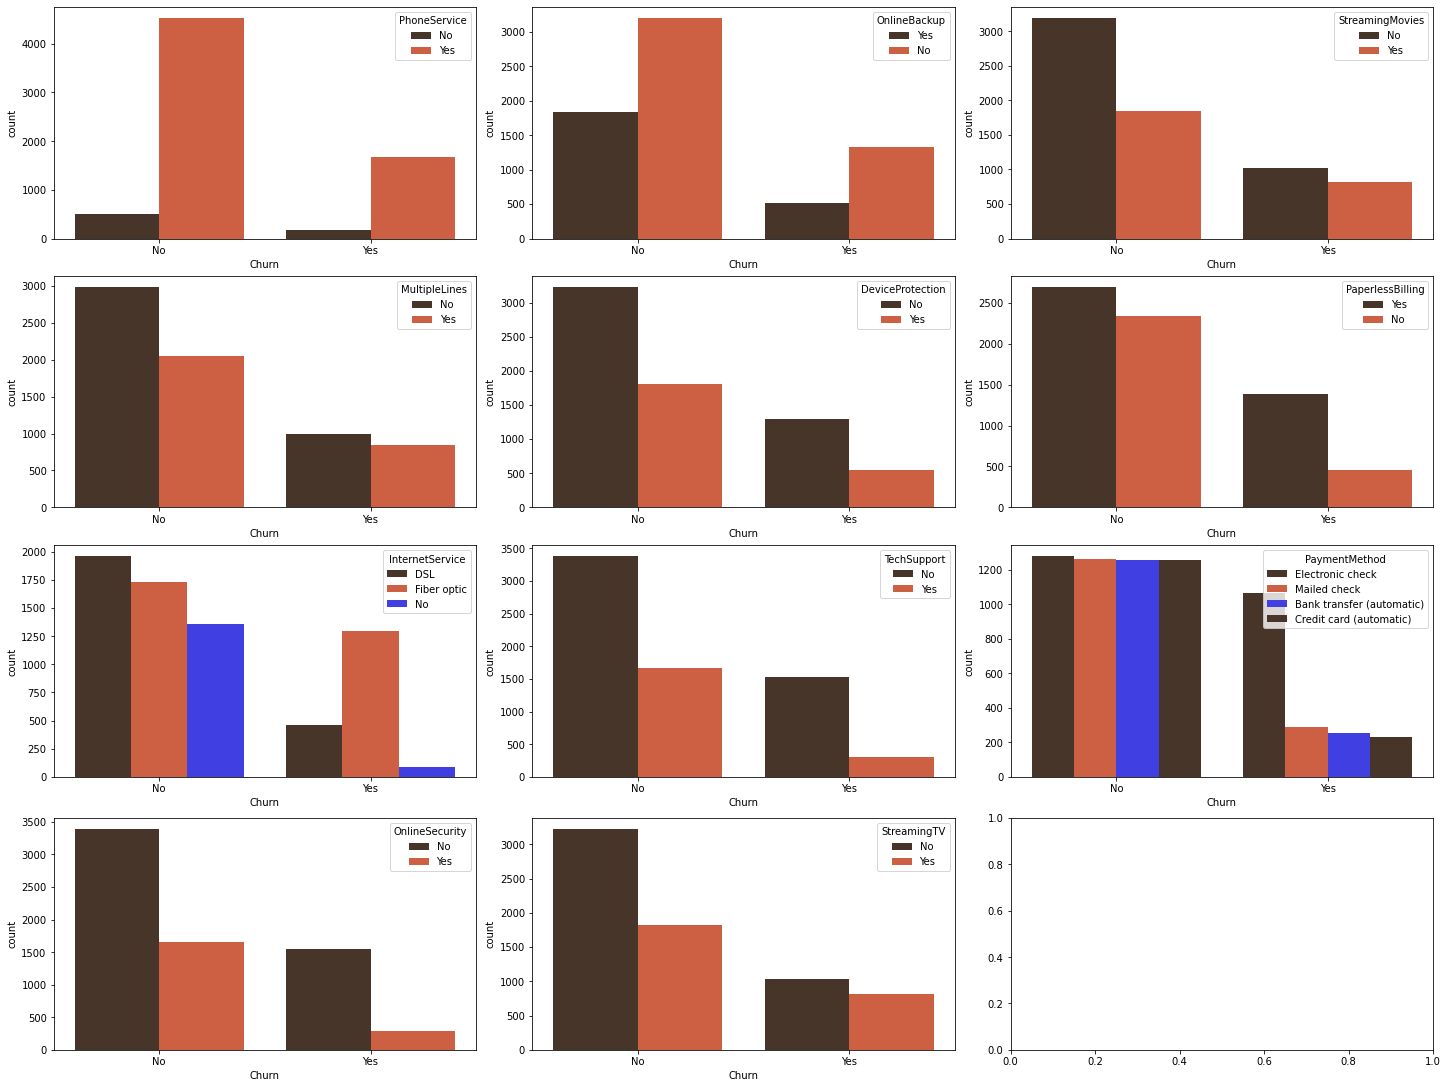

In [293]:
df=df.replace({'No internet service':'No', 'No phone service': 'No'})
services = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
           'OnlineBackup','DeviceProtection','TechSupport','StreamingTV','StreamingMovies','PaperlessBilling','PaymentMethod']

fig, axes = plt.subplots(nrows = 4,ncols = 3,figsize = (20,15),constrained_layout=True)

for i, item in enumerate(services):
    if i < 4:
        sns.countplot(
        x='Churn', 
        data=df, 
        palette=['#4D3425','#E4512B','#2424fd'],
        hue=item, ax=axes[i,0])
        
    elif i >=4 and i < 8:
        sns.countplot(
        x='Churn', 
        data=df, 
        palette=['#4D3425','#E4512B','#2424fd'],
        hue=item, ax=axes[i-4,1])
            
#         ax = (df[item].value_counts()/len(df)).plot(kind = 'bar',ax=axes[i-4,1],rot = 0)
        
    elif i < 11:
        sns.countplot(
        x='Churn', 
        data=df, 
        palette=['#4D3425','#E4512B','#2424fd'],
        hue=item, ax=axes[i-8,2])
        
#         ax = (df[item].value_counts()/len(df)).plot(kind = 'bar',ax=axes[i-8,2],rot = 0)
    ax.set_title(item)
#     elif i >9 and i<12:
#         ax = (df[item].value_counts()/len(df)).plot(kind = 'bar',ax=axes[i-9,],rot = 0)
#         ax.set_title(item)

#### Churn

Text(0.5, 1.0, 'Churn distribution')

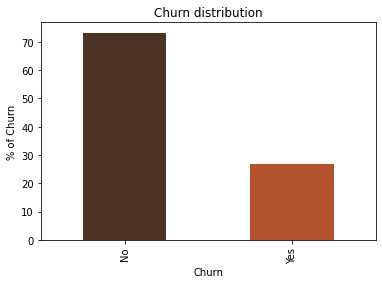

In [311]:
colors = ['#4D3425','#B4512F']
ax = (df['Churn'].value_counts()*100.0 /len(df)).plot(kind='bar', color = colors)

ax.set_ylabel('% of Customers')
ax.set_xlabel('Churn')
ax.set_ylabel('% of Churn')
ax.set_title('Churn distribution')

#### Registration Year

In [294]:
df.registration_time

0      2019-12-31
1      2017-03-31
2      2019-11-30
3      2016-04-30
4      2019-11-30
          ...    
7038   2018-01-31
7039   2014-01-31
7040   2019-02-28
7041   2019-09-30
7042   2014-07-31
Name: registration_time, Length: 6884, dtype: datetime64[ns]

In [295]:
df['registration_year'] = pd.DatetimeIndex(df['registration_time']).year
#df['registration_year'] = df['registration_year'].astype('int')

D:\pythonProject\Razorpay\churn_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '# of Customers by their Registration Year')

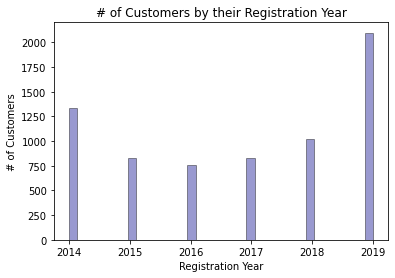

In [296]:
ax = sns.distplot(df['registration_year'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Registration Year')
ax.set_title('# of Customers by their Registration Year')

<AxesSubplot:xlabel='registration_year', ylabel='count'>

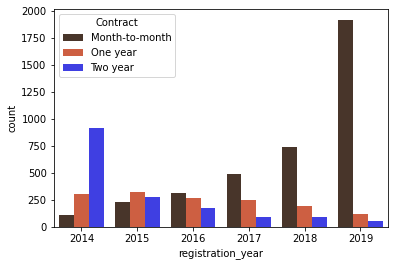

In [297]:
sns.countplot(
    x='registration_year', 
    data=df, 
    palette=['#4D3425','#E4512B','#2424fd'],
    hue='Contract')

In [298]:
df['registration_month'] = pd.DatetimeIndex(df['registration_time']).month

<AxesSubplot:xlabel='registration_month', ylabel='count'>

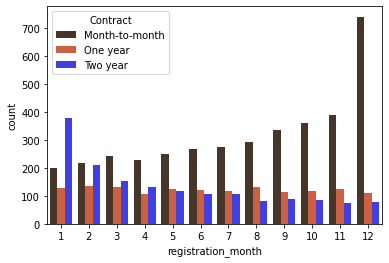

In [299]:
sns.countplot(
    x='registration_month', 
    data=df, 
    palette=['#4D3425','#E4512B','#2424fd'],
    hue='Contract')

## <a name="Hypothesis"></a>Hypothesis Testing

### <a name="H1"></a>Hypothesis 1:

**Null Hypothesis**: *There is no relation between the tenure of the user and their churn*
    
**Alternate Hypothesis**: *Tenure of the user is related to whether they will churn or not*

D:\pythonProject\Razorpay\churn_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '# of Customers by their tenure')

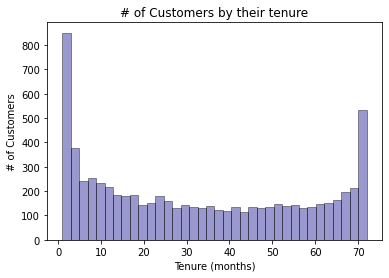

In [464]:
ax = sns.distplot(df['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('# of Customers by their tenure')



**Since the distribution of total charges is positively skewed, a transform is required to reduce the skew and make it follow a normal distribution**

1. **Box Cox Transform**
2. Log Transform
3. Square Root Transform

D:\pythonProject\Razorpay\churn_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '# of Customers by their Tenure')

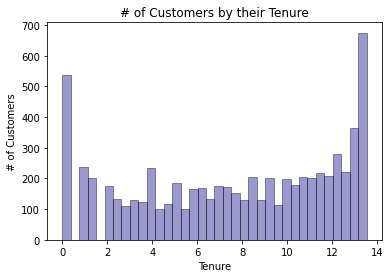

In [235]:
df_bc= df.copy()
#df_bc['total_charge_sqrt']= np.power(df_tf['TotalCharges'],(1/2))
df_bc['tenure_boxcox'], parameters=stats.boxcox(df_bc['tenure'])
ax = sns.distplot(df_bc['tenure_boxcox'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure')
ax.set_title('# of Customers by their Tenure')



<AxesSubplot:xlabel='tenure_boxcox', ylabel='Density'>

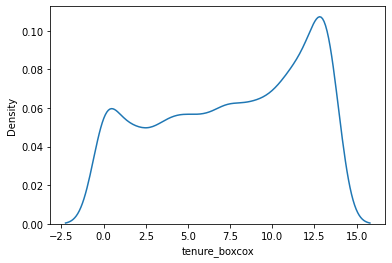

In [236]:
sns.kdeplot(df_bc.tenure_boxcox)

**Since the distribution of total charges is positively skewed, a transform is required to reduce the skew and make it follow a normal distribution**

1. Box Cox Transform
2. Log Transform
3. **Square Root Transform**

D:\pythonProject\Razorpay\churn_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '# of Customers by their Tenure')

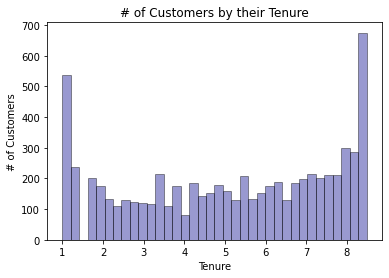

In [240]:
df_sr= df.copy()
#df_bc['total_charge_sqrt']= np.power(df_tf['TotalCharges'],(1/2))
df_sr['tenure_sqr']=np.power(df_sr['tenure'],(1/2))
ax = sns.distplot(df_sr['tenure_sqr'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Tenure')
ax.set_title('# of Customers by their Tenure')



<AxesSubplot:xlabel='tenure_sqr', ylabel='Density'>

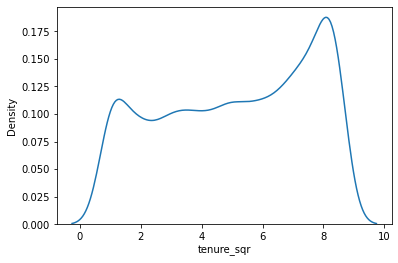

In [241]:
sns.kdeplot(df_sr.tenure_sqr)

### Observation

1. The tenure of customers follows a bi-modal distribution, i.e it has two peaks, one one the left and one on the right

Clarifications

1. Considering an error threshold (Alpha) of 0.05
After grouping the users into two groups, one that churned out and one that did not
Following are the results of multiple statistical tests to check how significantly different is the mean of tenure of both the groups 

2. One Way ANOVA, T test and Kruskal test have been used to determine the validity of the hypothesis, but because the input variable is not normally distributed, there is a high chance that this data does not represent the true relation between the means of the two groups.

3. Transformations such as box-cox, logarithmic transform, square root transform to reduce posivite skew were tried but it did not give a normal distribution in any case hence the original bimodal distribution is considered

There is a chance that this sample data is not representative of the population data so the result might not be completely inaccurate


In [466]:
stats.kruskal(df['tenure'][df['Churn']=='No'],df['tenure'][df['Churn']=='Yes'])

KruskalResult(statistic=960.7721092596182, pvalue=6.041799411641067e-211)

In [469]:
stats.f_oneway(df['tenure'][df['Churn']=='No'],df['tenure'][df['Churn']=='Yes'])

F_onewayResult(statistic=1007.5094314093412, pvalue=9.437650217603554e-207)

In [473]:
stats.ttest_ind(df['tenure'][df['Churn']=='No'],df['tenure'][df['Churn']=='Yes'])

Ttest_indResult(statistic=31.741289063447653, pvalue=9.437650217574845e-207)

1. In all three tests, we see that the P value is way below 0.001 and the statistic measure in each test is extremely large implying that the means of both the group are significantly different

**Based on statistical evidence, we can safely reject the null hypothesis and favor the alternate hypothesis, stating that The tenure of users significantly affects the churn of the users**

### <a name="H2"></a>Hypothesis 2

**Null Hypothesis**: *There is no relation between the total charges given by a user and his/her churn*

**Alternate Hypothesis**: *Total charges given by a user is related to his/her churn*

In [415]:
df.skew(axis = 0, skipna = True)

C:\Users\irish\AppData\Local\Temp\ipykernel_28916\2838370498.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.skew(axis = 0, skipna = True)


tenure                0.238661
MonthlyCharges       -0.247273
TotalCharges          0.932209
base                  0.000000
registration_year    -0.171533
registration_month    0.220227
dtype: float64

- Total Charges is moderately positively skewed

D:\pythonProject\Razorpay\churn_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '# of Customers by their Total Charges')

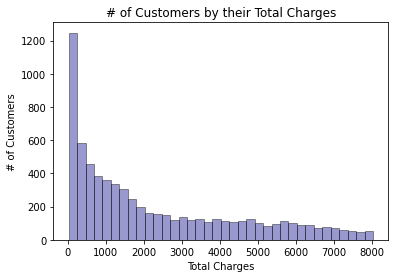

In [223]:
#df2= df.query('Churn=="No"')
ax = sns.distplot(df['TotalCharges'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Total Charges')
ax.set_title('# of Customers by their Total Charges')



**Since the distribution of total charges is positively skewed, a transform is required to reduce the skew and make it follow a normal distribution**

1. Box Cox Transform
2. Log Transform
3. **Square Root Transform**

D:\pythonProject\Razorpay\churn_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '# of Customers by their Total Charges')

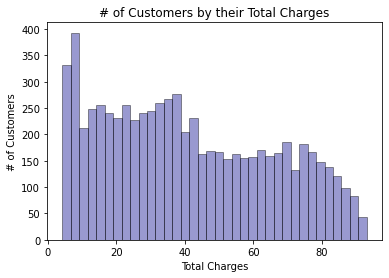

In [481]:
df_tf= df.copy()
df_tf['total_charge_sqrt']= np.power(df_tf['TotalCharges'],(1/2))
#df_tf['total_charge_boxcox'], parameters=stats.boxcox(df_tf['TotalCharges'])
ax = sns.distplot(df_tf['total_charge_sqrt'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Total Charges')
ax.set_title('# of Customers by their Total Charges')



<AxesSubplot:xlabel='total_charge_sqrt', ylabel='Density'>

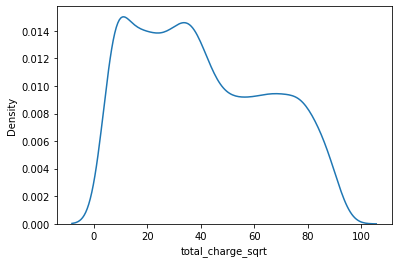

In [482]:
sns.kdeplot(df_tf.total_charge_sqrt)

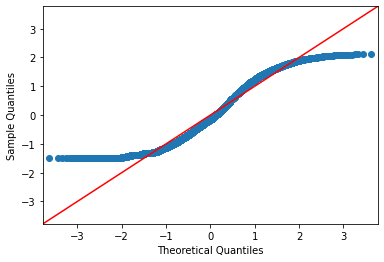

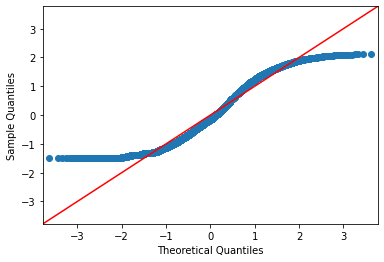

In [483]:

sm.qqplot(df_tf['total_charge_sqrt'],line='45',fit=True,dist=stats.norm)

**Since the distribution of total charges is positively skewed, a transform is required to reduce the skew and make it follow a normal distribution**

1. **Box Cox Transform**
2. Log Transform
3. Square Root Transform

D:\pythonProject\Razorpay\churn_prediction\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, '# of Customers by their Total Charges')

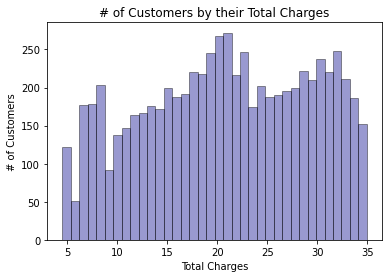

In [227]:
df_bc= df.copy()
#df_bc['total_charge_sqrt']= np.power(df_tf['TotalCharges'],(1/2))
df_bc['total_charge_boxcox'], parameters=stats.boxcox(df_bc['TotalCharges'])
ax = sns.distplot(df_bc['total_charge_boxcox'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('# of Customers')
ax.set_xlabel('Total Charges')
ax.set_title('# of Customers by their Total Charges')



<AxesSubplot:xlabel='total_charge_boxcox', ylabel='Density'>

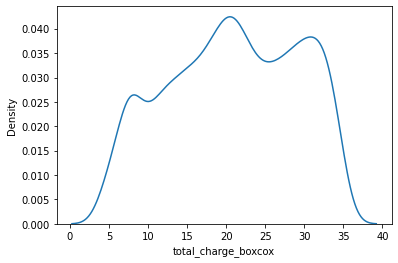

In [228]:
sns.kdeplot(df_bc.total_charge_boxcox)

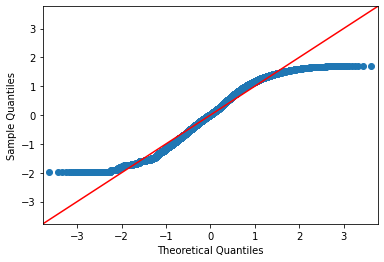

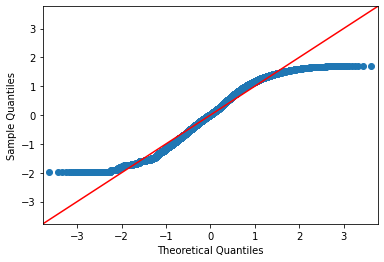

In [230]:

sm.qqplot(df_bc['total_charge_boxcox'],line='45',fit=True,dist=stats.norm)

In [234]:
ttest_ind(df_bc['total_charge_boxcox'][df_bc['Churn']=='No'], df_bc['total_charge_boxcox'][df_bc['Churn']=='Yes'])

Ttest_indResult(statistic=20.170408765478847, pvalue=5.971406636415396e-88)

In [484]:
#stats.f_oneway(df_tf['total_charge_sqrt'][df_tf['Churn']=='No'], df_tf['total_charge_sqrt'][df_tf['Churn']=='Yes'])

F_onewayResult(statistic=375.5357036199929, pvalue=1.519465741805565e-81)

Since the p value is less than 0.001, we can safely reject the null hypothesis and say that the difference in means of the two groups is statistically significant

This means that there is a significant differentiation in the total charge of users that have churned and users that have not churned
